In [1]:
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from rasterio.plot import show
from pyproj import CRS
from pyproj import Transformer
import numpy as np
import json


In [2]:
#Settings
in_file_name = 'eu_dem_v11_E40N20.TIF'
peak_data = 'Peaks.json'
out_file_name = 'eu_dem_v11_E40N20_peaks.TIF'

In [3]:
# read file
with open(peak_data, encoding="utf8") as myfile:
    data=myfile.read()
    
# parse file
data_dict = json.loads(data)

coordinates = []
# show values
for i in range(0,len(data_dict["features"])):  
     coordinates.append(data_dict["features"][i]["geometry"]["coordinates"])
        


In [4]:
#Coordinate System of OSM
crs_osm = CRS.from_epsg(4326)

#coordinete System of copernicus 
with rasterio.open(in_file_name) as src:
    #Export Coordinate System to pyprj
    crs_eu = CRS.from_wkt(src.crs.wkt)
    eu_to_pos = src.transform.__invert__()
    shape = np.array(src.shape)


#make transformer from osm to eu
osm_to_eu = Transformer.from_crs(crs_osm, crs_eu)
#make ground Truth array
peaks = np.zeros(shape, dtype=bool)


In [5]:
positions = []
c = 0
for (y,x) in coordinates:
    #transfrom coordinates
    eu = osm_to_eu.transform(x,y)
    pos = np.array(eu_to_pos * eu)
    
    positions.append(pos)
    #Round to the next possible coordinate and set that to 1
    intpos = np.array((pos[0]+0.5, pos[1]+0.5), dtype=np.uint16)
    #Because extracted area apparently is larger than expected
    if np.all(np.logical_and(intpos>0, intpos < 40000)):
        peaks[intpos[0]][intpos[1]] = 1
        c+=1

In [6]:
# Save image
with rasterio.Env():
    
    with rasterio.open(in_file_name) as src:
        profile = src.profile
    
    profile.update(
        count=1,
        nbits=1
        )
    with rasterio.open(out_file_name, 'w', **profile) as dst:
        dst.write(peaks.astype(rasterio.ubyte), 1)

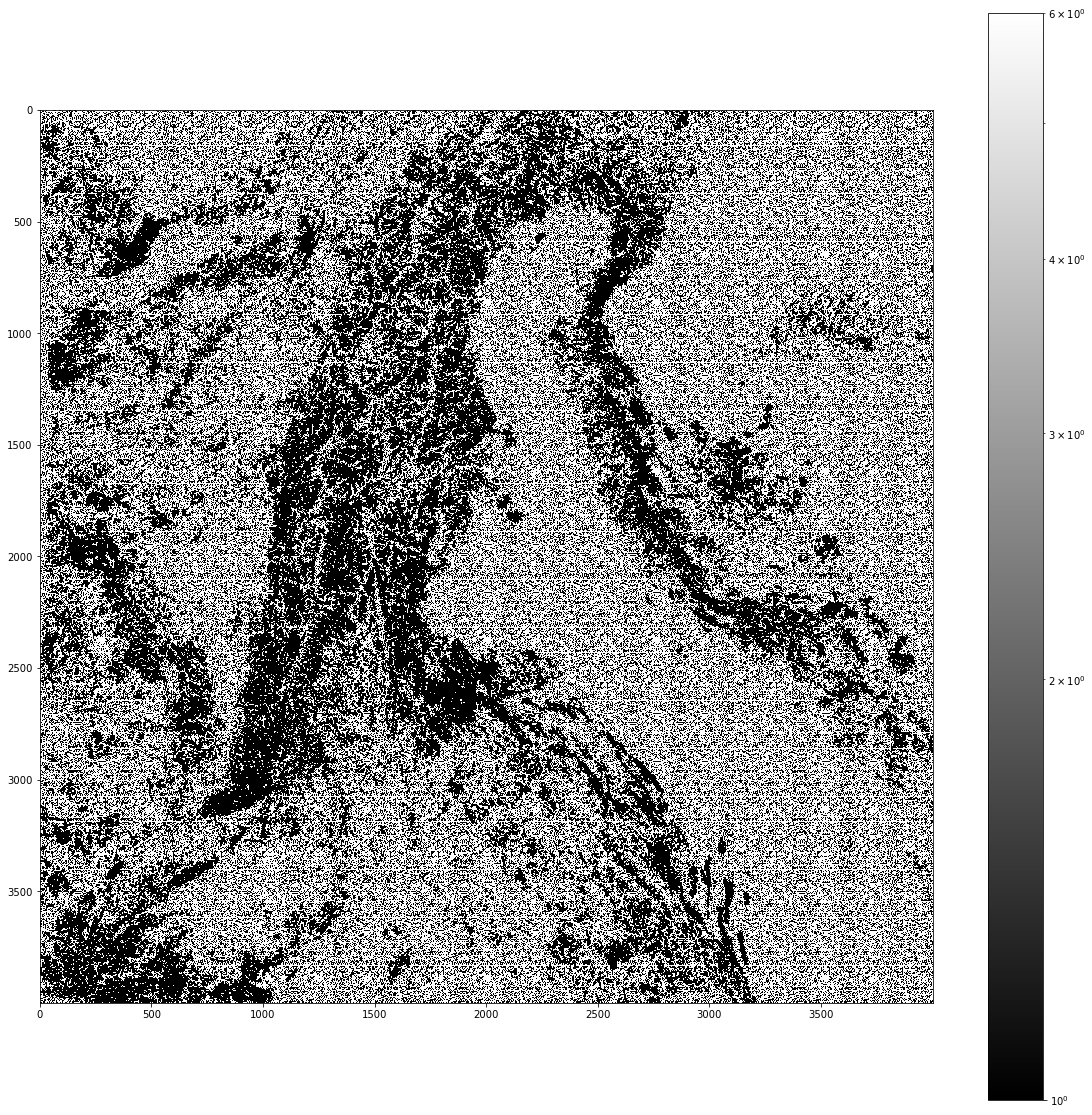

In [32]:
from matplotlib.colors import LogNorm

#Visualize Peaks
plt.figure(figsize=(20,20))
def downscale(image, factor, shape = None):
    
    try:
        n_stepX = shape[0]/factor
        n_stepY = shape[1]/factor
    except:
        shape = image.shape
        n_stepX = shape[0]/factor
        n_stepY = shape[1]/factor

    
    step = 1/factor
    newImage = np.zeros((int(shape[0]/factor), int(shape[1]/factor)))
    for index in np.ndindex(newImage.shape):
        newImage[index] = np.sum((image[index[0]*factor: (index[0]+1)*factor, index[1]*factor: (index[1]+1)*factor]))
    return newImage
plt.imshow(downscale(peaks, 10), cmap = 'gray', norm=LogNorm())
plt.colorbar()
plt.savefig('peak_distribution.png', dpi=50)

In [20]:
# To Display the Satellite Image:

def raster_downscale(src, factor):
    shape = src.shape
    n_stepX = shape[0]/factor
    n_stepY = shape[1]/factor

    
    step = 1/factor
    newImage = np.zeros((int(shape[0]/factor), int(shape[1]/factor)))
    for index in np.ndindex(newImage.shape):
        newImage[index] = np.average(src.read(1, window = Window(index[0]*factor, index[1]*factor, factor, factor)))
    return newImage

In [21]:
with rasterio.open(in_file_name) as src:
    image= raster_downscale(src, 50)


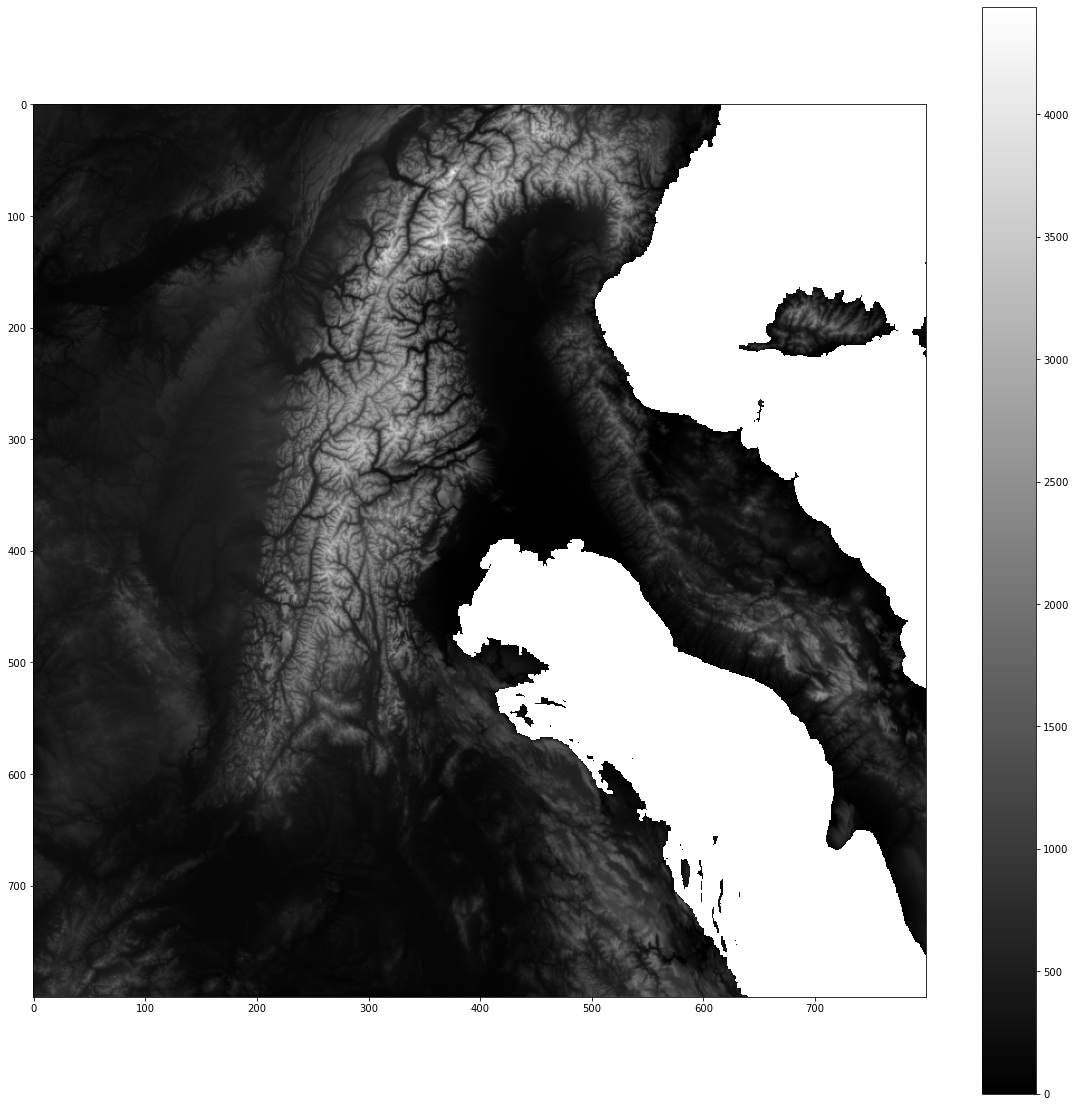

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(image, vmin = 0, cmap='gray')
plt.colorbar()